# **DermoAI: Multimodal Dermatology Triage Assistant**

# **1. Structured Overview**


## 🧩 **Why Multimodal Triage is Essential**

Multimodal approaches—integrating **clinical photos, dermoscopy, patient demographics, history, and conversational** input—bridge key gaps:

1. **Holistic Understanding**: Combines lesion appearance with relevant metadata (e.g. age, symptoms) to improve clinical reasoning.
2. **Triage Precision**: Stratifies cases into **_urgent referral_, _routine check_, or _self‑care_** efficiently.
3. **Equitable Care**: Addresses biases, including **darker skin tones** and underrepresented conditions by leveraging diverse data sources.


## **🩺 The DermoAI Triage Assistant**

Our DermoAI assistant extends this multimodal paradigm to triage:
- **Input**: Smartphone image + patient metadata + interactive chatbot dialogue
- **Goal**: Rapidly determine urgency—“Urgent referral?”, “Routine?”, or “Advice?”
- **Outcome**: Improve patient flow, reduce wait times, and support primary care providers

---

<br>

> ⚠️ **Ethical Note**: While AI can significantly improve access, careful validation, bias auditing, and human-in-the-loop oversight are essential to ensure safe, equitable deployment.




---



---



A comprehensive AI-powered dermatology triage system that analyzes:
- Skin lesion images using **BLIP-2** vision model
- Audio symptom descriptions using **Whisper** speech-to-text
- Text-based medical history using **sentence transformers**



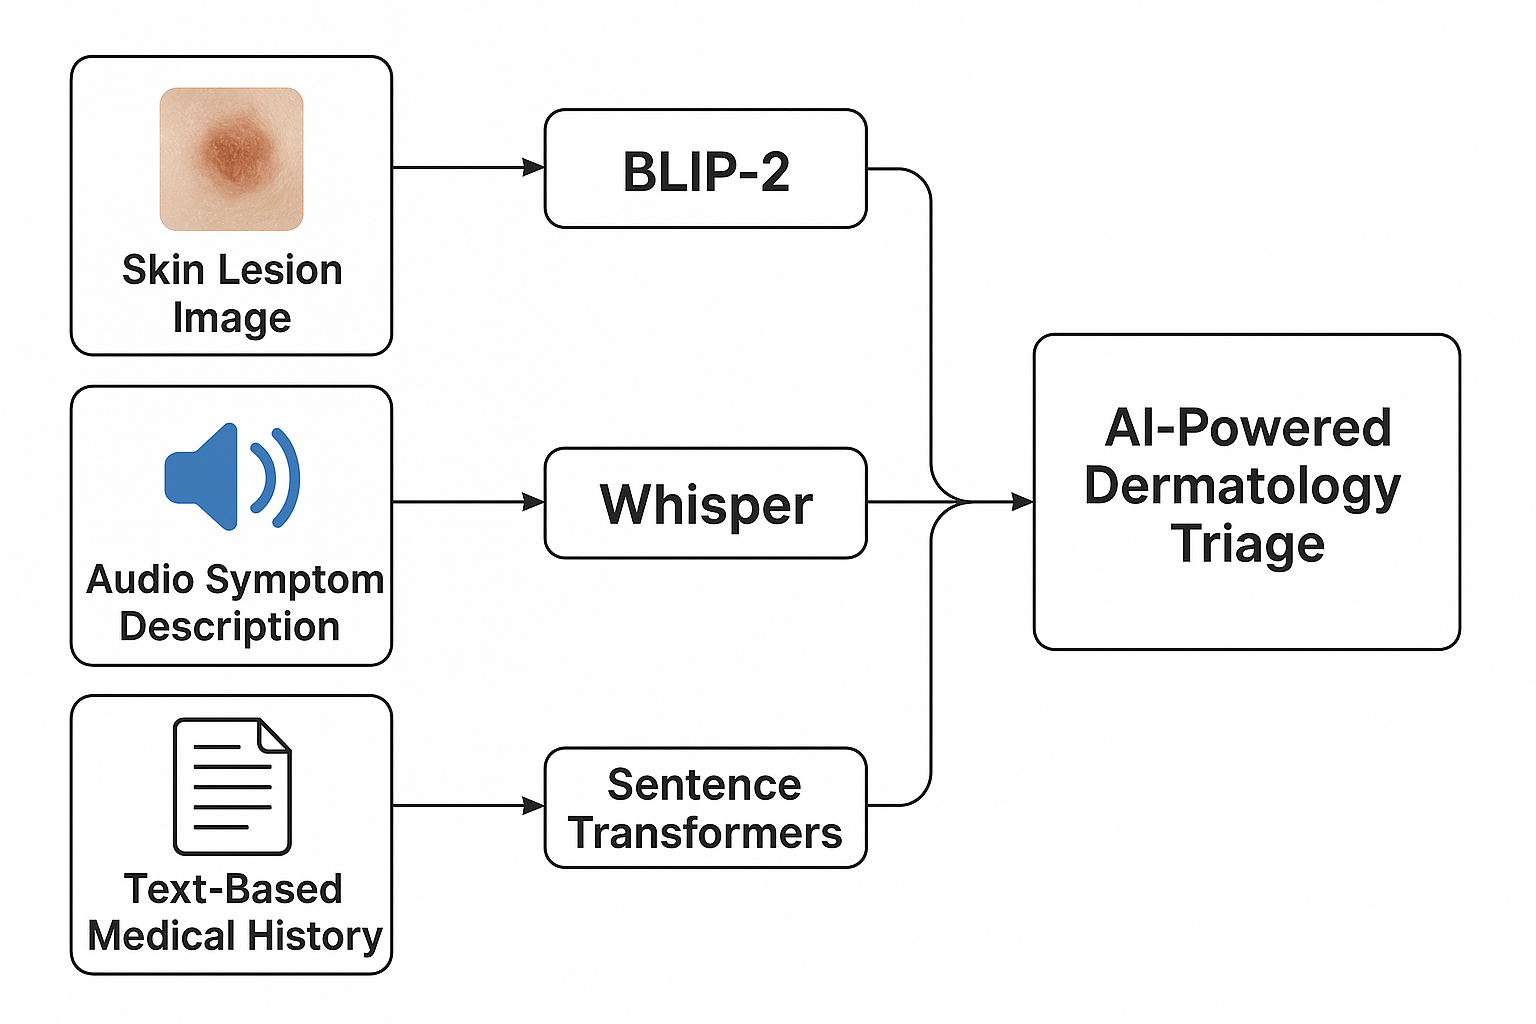

## Environment Setup & GPU Configuration

In [ ]:
# Check GPU availability and setup
import torch
import os

print("System Information:")
print(f"Python version: {os.sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    device = torch.device('cuda')
else:
    print("GPU not available, using CPU")
    device = torch.device('cpu')

print(f"Using device: {device}")

System Information:
Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
PyTorch version: 2.6.0+cu124
CUDA available: True
GPU Device: Tesla T4
GPU Memory: 15.8 GB
Using device: cuda


In [ ]:
# Install required packages
!pip install -q streamlit
!pip install -q transformers
!pip install -q torch torchvision
!pip install -q sentence-transformers
!pip install -q pillow
!pip install -q opencv-python
!pip install -q soundfile
!pip install -q librosa
!pip install -q faiss-cpu
!pip install -q numpy
!pip install -q scipy
!pip install -q pyngrok

print("All dependencies installed successfully!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.

## Core AI Models & Processors

In [ ]:
%%writefile image_processor.py
import torch
import numpy as np
from PIL import Image
import cv2
from typing import Dict, Any
import logging
from transformers import BlipProcessor, BlipForConditionalGeneration

logger = logging.getLogger(__name__)

class ImageProcessor:
    def __init__(self, device='cuda'):
        self.device = device
        self.model = None
        self.processor = None
        self._load_models()

    def _load_models(self):
        try:
            logger.info("Loading BLIP model for image analysis...")
            model_name = "Salesforce/blip-image-captioning-base"

            self.processor = BlipProcessor.from_pretrained(model_name)
            self.model = BlipForConditionalGeneration.from_pretrained(model_name)

            if torch.cuda.is_available() and self.device == 'cuda':
                self.model = self.model.to(self.device)

            self.model.eval()
            logger.info(f"BLIP model loaded successfully on {self.device}")

        except Exception as e:
            logger.error(f"Error loading BLIP model: {e}")
            self.model = None
            self.processor = None

    # Turns the image into a “feature vector” (a list of numbers) that summarizes its content for the AI.
    def process_image(self, image: Image.Image) -> np.ndarray:
        try:
            if self.model is None:
                return np.random.randn(768)

            processed_image = self._preprocess_image(image) # Preprocess the image (resize, convert to correct color)
            inputs = self.processor(processed_image, return_tensors="pt")

            if torch.cuda.is_available() and self.device == 'cuda':
                inputs = {k: v.to(self.device) for k, v in inputs.items()}

            with torch.no_grad():
                outputs = self.model.vision_model(**{k: v for k, v in inputs.items() if k in ['pixel_values']})
                features = outputs.last_hidden_state.mean(dim=1).cpu().numpy()[0] # Use BLIP’s vision model to extract features

            return features

        except Exception as e:
            logger.error(f"Error processing image: {e}")
            return np.random.randn(768) # If the model fails, returns random features (so the pipeline doesn’t break)

    # Describes the image in medical terms
    def generate_caption(self, image: Image.Image) -> str:
        try:
            if self.model is None:
                return "Image analysis unavailable - model not loaded"

            prompt = "A detailed medical description of this skin lesion showing"
            processed_image = self._preprocess_image(image)

            inputs = self.processor(processed_image, prompt, return_tensors="pt")

            if torch.cuda.is_available() and self.device == 'cuda':
                inputs = {k: v.to(self.device) for k, v in inputs.items()}

            with torch.no_grad():
                outputs = self.model.generate(**inputs, max_length=100, num_beams=5, early_stopping=True)
                caption = self.processor.decode(outputs[0], skip_special_tokens=True) # Uses BLIP to generate a detailed caption (“A detailed medical description of this skin lesion showing ...”)

            enhanced_caption = self._enhance_medical_terminology(caption) # Enhances the wording to use more medical language (e.g., “spot” becomes “lesion”)
            return enhanced_caption

        except Exception as e:
            logger.error(f"Error generating caption: {e}")
            return f"Basic image analysis: {self._basic_visual_analysis(image)}" # If the model fails, uses a basic color/shape analysis instead

    def _preprocess_image(self, image: Image.Image) -> Image.Image:
        try:
            if image.mode != 'RGB':
                image = image.convert('RGB')

            max_size = 512
            if max(image.size) > max_size:
                ratio = max_size / max(image.size)
                new_size = (int(image.size[0] * ratio), int(image.size[1] * ratio))
                image = image.resize(new_size, Image.Resampling.LANCZOS)

            return image

        except Exception as e:
            logger.error(f"Error preprocessing image: {e}")
            return image

    def _enhance_medical_terminology(self, caption: str) -> str:
        medical_terms = {
            'spot': 'lesion',
            'mark': 'marking',
            'bump': 'papule',
            'red': 'erythematous',
            'dark': 'hyperpigmented',
            'light': 'hypopigmented'
        }

        enhanced = caption.lower()
        for common, medical in medical_terms.items():
            enhanced = enhanced.replace(common, medical)

        return enhanced.capitalize()

    # This function provides a basic, quick description of the image by looking at its colors, without using any AI model
    def _basic_visual_analysis(self, image: Image.Image) -> str:
        try:
            img_array = np.array(image)
            mean_color = img_array.mean(axis=(0, 1))

            if mean_color[0] > 150:
                color_desc = "reddish lesion"
            elif mean_color.mean() < 100:
                color_desc = "dark pigmented lesion"
            else:
                color_desc = "skin lesion"

            return f"Visible {color_desc} requiring medical evaluation"

        except Exception:
            return "Skin lesion visible in image"

    # Checks if the image is suitable for medical review
      # 1- Measures sharpness (is it blurry?), brightness (too dark/bright?), and resolution (size)
      # 2- Gives a quality score (out of 100) and a summary (good, fair, poor)
      # 3- Lists any problems (e.g., blurry, too small)
    def analyze_image_quality(self, image: Image.Image) -> Dict[str, Any]:
        try:
            img_array = np.array(image)
            sharpness = cv2.Laplacian(cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY), cv2.CV_64F).var()
            brightness = img_array.mean()

            quality_score = 100
            issues = []

            if sharpness < 100:
                issues.append("Image may be blurry")
                quality_score -= 20

            if brightness < 50:
                issues.append("Image is too dark")
                quality_score -= 15
            elif brightness > 200:
                issues.append("Image is too bright")
                quality_score -= 15

            if min(image.size) < 200:
                issues.append("Image resolution is low")
                quality_score -= 25

            quality = "good" if quality_score >= 70 else "fair" if quality_score >= 50 else "poor"

            return {
                "quality": quality,
                "score": max(0, quality_score),
                "sharpness": sharpness,
                "brightness": brightness,
                "resolution": image.size,
                "issues": issues
            }

        except Exception as e:
            logger.error(f"Error analyzing image quality: {e}")
            return {"quality": "unknown", "issues": ["Quality analysis failed"]}

Writing image_processor.py


In [ ]:
%%writefile audio_processor.py
import torch
import numpy as np
import librosa
import tempfile
import os
from typing import Optional, Dict, Any
import logging
from transformers import WhisperProcessor, WhisperForConditionalGeneration

logger = logging.getLogger(__name__)

class AudioProcessor:
    def __init__(self, device='cuda'):
        self.device = device
        self.model = None
        self.processor = None
        self._load_models()

    # Loads the HuggingFace Whisper model for transcribing medical speech. We will use GPU is available
    def _load_models(self):
        try:
            logger.info("Loading Whisper model for audio processing...")
            model_name = "openai/whisper-small"

            self.processor = WhisperProcessor.from_pretrained(model_name)
            self.model = WhisperForConditionalGeneration.from_pretrained(model_name)

            if torch.cuda.is_available() and self.device == 'cuda':
                self.model = self.model.to(self.device)

            self.model.eval()
            logger.info(f"Whisper model loaded successfully on {self.device}")

        except Exception as e:
            logger.error(f"Error loading Whisper model: {e}")
            self.model = None
            self.processor = None

    # Turns the patient’s speech (audio) into written text
      # 1- Loads and processes the audio
      # 2- Runs Whisper model to transcribe speech
      # 3- Cleans up the transcript for medical use
    def transcribe_audio(self, audio_file) -> str:
        if self.model is None or self.processor is None:
            return "Error: Whisper model not loaded"

        try:
            audio_data = self._load_audio(audio_file)
            if audio_data is None:
                return "Error: Could not load audio file"

            inputs = self.processor(audio_data, sampling_rate=16000, return_tensors="pt")

            if torch.cuda.is_available() and self.device == 'cuda':
                inputs = {k: v.to(self.device) for k, v in inputs.items()}

            with torch.no_grad():
                predicted_ids = self.model.generate(**inputs)
                transcription = self.processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]

            medical_transcript = self.preprocess_for_medical_context(transcription)
            return medical_transcript

        except Exception as e:
            logger.error(f"Error transcribing audio: {e}")
            return f"Error: Transcription failed - {str(e)}"

    # Turns audio into a feature vector (numerical summary) for further AI analysis
      # 1- Loads the audio file
      # 2- Extracts MFCCs (standard features in audio analysis)
      # 3- Combines stats (mean, std, max, min) into a single vector
    def extract_features(self, audio_file) -> Optional[np.ndarray]:
        try:
            audio_data = self._load_audio(audio_file)
            if audio_data is None:
                return None

            mfccs = librosa.feature.mfcc(y=audio_data, sr=16000, n_mfcc=13)

            features = np.concatenate([
                mfccs.mean(axis=1),
                mfccs.std(axis=1),
                mfccs.max(axis=1),
                mfccs.min(axis=1)
            ])

            target_size = 384
            if len(features) < target_size:
                features = np.pad(features, (0, target_size - len(features)))
            else:
                features = features[:target_size]

            return features

        except Exception as e:
            logger.error(f"Error extracting audio features: {e}")
            return None

    # Reads audio from different file formats (path or in-memory bytes)
      # 1- Handles both file paths and uploaded files
      # 2- Always converts to 16kHz mono format for consistency
    def _load_audio(self, audio_file) -> Optional[np.ndarray]:
        try:
            if isinstance(audio_file, str):
                audio_data, sr = librosa.load(audio_file, sr=16000, mono=True)
            else:
                if hasattr(audio_file, 'read'):
                    audio_bytes = audio_file.read()
                else:
                    audio_bytes = audio_file

                with tempfile.NamedTemporaryFile(delete=False, suffix='.wav') as tmp_file:
                    tmp_file.write(audio_bytes)
                    tmp_path = tmp_file.name

                try:
                    audio_data, sr = librosa.load(tmp_path, sr=16000, mono=True)
                finally:
                    os.unlink(tmp_path)

            return audio_data

        except Exception as e:
            logger.error(f"Error loading audio: {e}")
            return None

    # Checks if the audio is clear and useful
      # 1- Measures duration and loudness (RMS energy)
      # 2- Flags issues (too short, too loud, too quiet, too long)
      # 3- Gives a quality score and a “good/fair/poor” label
    def analyze_audio_quality(self, audio_file) -> Dict[str, Any]:
        try:
            audio_data = self._load_audio(audio_file)
            if audio_data is None:
                return {"quality": "error", "issues": ["Could not load audio"]}

            duration = len(audio_data) / 16000
            rms_energy = np.sqrt(np.mean(audio_data**2))

            issues = []
            quality_score = 100

            if duration < 1:
                issues.append("Audio too short")
                quality_score -= 30
            elif duration > 300:
                issues.append("Audio very long")
                quality_score -= 10

            if rms_energy < 0.01:
                issues.append("Audio too quiet")
                quality_score -= 25
            elif rms_energy > 0.5:
                issues.append("Audio may be too loud")
                quality_score -= 15

            quality = "good" if quality_score >= 70 else "fair" if quality_score >= 50 else "poor"

            return {
                "quality": quality,
                "score": max(0, quality_score),
                "duration": duration,
                "energy": rms_energy,
                "issues": issues
            }

        except Exception as e:
            logger.error(f"Error analyzing audio quality: {e}")
            return {"quality": "error", "issues": ["Quality analysis failed"]}

    # Replaces casual words in the transcript with formal medical terms
      # Example: “itchy” becomes “pruritic”; “rash” becomes “skin eruption”
    def preprocess_for_medical_context(self, transcript: str) -> str:
        try:
            medical_corrections = {
                'itchy': 'pruritic',
                'itching': 'pruritus',
                'rash': 'skin eruption',
                'bump': 'papule',
                'red': 'erythematous',
                'swollen': 'edematous',
                'hurts': 'painful',
                'burning': 'burning sensation'
            }

            processed = transcript.lower()

            for informal, formal in medical_corrections.items():
                processed = processed.replace(informal, formal)

            return processed.capitalize()

        except Exception as e:
            logger.error(f"Error preprocessing transcript: {e}")
            return transcript

Writing audio_processor.py


In [ ]:
%%writefile text_processor.py
import numpy as np
from typing import Dict, Any
import logging
import re
from sentence_transformers import SentenceTransformer
import torch

logger = logging.getLogger(__name__)

class TextProcessor:
    def __init__(self, device='cuda'):
        self.device = device
        self.model = None
        self.medical_keywords = self._load_medical_keywords()
        self._load_models()

    # Loads the sentence transformer (MiniLM) to turn text into embeddings (vectors)
    def _load_models(self):
        try:
            logger.info("Loading sentence transformer for text processing...")
            model_name = 'all-MiniLM-L6-v2'

            self.model = SentenceTransformer(model_name)

            if self.device == 'cuda' and torch.cuda.is_available():
                self.model = self.model.to(self.device)

            logger.info(f"Sentence transformer loaded successfully on {self.device}")

        except Exception as e:
            logger.error(f"Error loading sentence transformer: {e}")
            self.model = None

    # Sets up lists of important medical keywords for skin conditions, symptoms, time words, and severity
     # Usage: Helps in matching relevant words in the patient text
    def _load_medical_keywords(self) -> Dict[str, list]:
        return {
            'skin_conditions': [
                'rash', 'lesion', 'spot', 'mole', 'bump', 'growth', 'patch',
                'discoloration', 'scaling', 'peeling', 'cracking', 'blistering'
            ],
            'symptoms': [
                'itching', 'burning', 'pain', 'tenderness', 'swelling',
                'redness', 'warmth', 'numbness', 'tingling'
            ],
            'temporal': [
                'sudden', 'gradual', 'recent', 'chronic', 'acute',
                'days', 'weeks', 'months', 'years'
            ],
            'severity': [
                'mild', 'moderate', 'severe', 'intense', 'slight',
                'worsening', 'improving', 'stable'
            ]
        }

    # Converts the text into a numerical vector (“embedding”) that captures its meaning
     # 1- Cleans and standardizes the text
     # 2- Uses the sentence transformer to create the embedding
    def extract_features(self, text: str) -> np.ndarray:
        try:
            if self.model is None:
                return np.random.randn(384)

            processed_text = self._preprocess_text(text)
            embeddings = self.model.encode(processed_text, convert_to_numpy=True)

            return embeddings

        except Exception as e:
            logger.error(f"Error extracting text features: {e}")
            return np.random.randn(384)

    # Cleans up the text for analysis
      # 1- Lowercases, removes punctuation, and standardizes terms (e.g., “itchy” → “pruritic”)
    def _preprocess_text(self, text: str) -> str:
        try:
            text = re.sub(r'[^\w\s]', ' ', text.lower())
            text = re.sub(r'\s+', ' ', text).strip()
            text = self._standardize_medical_terms(text)
            return text

        except Exception as e:
            logger.error(f"Error preprocessing text: {e}")
            return text

    # Replaces casual terms with formal medical language (e.g., “bump” → “papule”)
    def _standardize_medical_terms(self, text: str) -> str:
        replacements = {
            'itchy': 'pruritic',
            'rash': 'skin eruption',
            'bump': 'papule',
            'red': 'erythematous',
            'swollen': 'edematous'
        }

        for old, new in replacements.items():
            text = text.replace(old, new)

        return text

    # Looks for medical keywords in the text and determines how urgent the symptoms sound
     # 1- Scans for each category of keyword
     # 2- Assigns an urgency level (“low”, “medium”, or “high”) based on the number of urgent words found
    def analyze_symptoms(self, text: str) -> Dict[str, Any]:
        try:
            text_lower = text.lower()
            analysis = {}

            for category, keywords in self.medical_keywords.items():
                found_keywords = [kw for kw in keywords if kw in text_lower]
                analysis[category] = found_keywords

            urgent_keywords = ['sudden', 'severe', 'intense', 'bleeding', 'spreading']
            urgency_score = sum(1 for kw in urgent_keywords if kw in text_lower)

            if urgency_score >= 2:
                urgency = 'high'
            elif urgency_score == 1:
                urgency = 'medium'
            else:
                urgency = 'low'

            analysis['urgency'] = urgency
            analysis['urgency_score'] = urgency_score

            return analysis

        except Exception as e:
            logger.error(f"Error analyzing symptoms: {e}")
            return {'urgency': 'unknown'}

Writing text_processor.py


# 📊 **AttentionFusionLayer Architecture**

## **Key Flow**:

### **🔹 Input Features:**
1. **Image Features (e.g., what the AI "sees")**: `image_features` (NumPy or Tensor), shape: `[batch, feature_dim]`
2.  **Text Features (e.g., user descriptions or notes)**: `text_features` (NumPy or Tensor), shape: `[batch, feature_dim]`
3.  **Audio Features (optional; if missing, it’s filled with zeros)**: `audio_features` (optional; default is zeros if missing), shape: `[batch, feature_dim]`

### **🔹 Concatenation: All features are joined (concatenated) into one long vector**
- Concatenate image, text, and audio features along the feature dimension.
- **Resulting vector size:** **`feature_dim * 3`** → This "super-vector" holds all the information from every input source.

### **🔹 Attention Network: the network learns to decide how much to trust each source for every case**
- **Architecture**:  
  `Linear(feature_dim * 3 → feature_dim)` → `ReLU` → `Linear(feature_dim → 3)` → `Softmax`
- **Output**:  
It produces **three numbers** (attention weights `[w_image, w_text, w_audio]`), one for each modality (image, text, audio), where each sample’s weights sum to 1.


### **🔹 Weighted Feature Computation:**
- Each feature vector is multiplied by its **`attention weight`**.
  + → **For instance:** If image is more important, it gets a bigger slice.
- The weighted vectors are then **added up** to form a **single**, blended feature.

- **Output shape:** `[batch, feature_dim]`.

### **🔹 Fusion Network: This blended feature is sent through a small neural network (a few layers)**
- **Architecture**:  
  `Linear(feature_dim → feature_dim)` → `ReLU` → `Dropout` → `Linear(feature_dim → feature_dim)`

- → This helps the model capture **complex relationships** between different types of data.



### **🔹 L2 Normalization:**
- Finally, the resulting vector is scaled (L2 normalization) so that it always has the same length.
- → This keeps the outputs **consistent** and helps with further processing.




# 📋 **Summary Table**

| **Step**             | **What Happens**                                                       |
|----------------------|------------------------------------------------------------------------|
| **Input Features**   | Get image, text, and optional audio features                           |
| **Concatenation**    | Join them into one big vector                                          |
| **Attention Network**| Compute importance weights for each input                              |
| **Weighted Mixing**  | Scale each feature by its weight and add them up                       |
| **Fusion Network**   | Refine the blended feature using a small neural network                |
| **Normalization**    | Scale the result for consistency                                       |


## **In Short:**

The **`AttentionFusionLayer`** learns how much to **trust each input modality** and then combines them into a **single, compact representation**.  

  +  →→ This approach is especially powerful for **medical** or **multimodal tasks**, where the most relevant information can **vary dynamically from case to case**.




In [ ]:
%%writefile fusion_layer.py
import torch
import torch.nn as nn
import numpy as np
from typing import Optional, Dict
import logging

logger = logging.getLogger(__name__)

class AttentionFusionLayer:
    def __init__(self, feature_dim: int = 384, device='cuda'):
        self.feature_dim = feature_dim
        self.device = device
        self.attention_network = self._build_attention_network()
        self.fusion_network = self._build_fusion_network()

    # Creates a mini neural network (attention) that decides how much to trust each input (image, text, audio)
    # Learns weights for each modality by looking at all their features together
      # Inside:
        # Uses two linear layers with ReLU and softmax for final attention weights
        # Returns three numbers: the weights for image, text, audio (add up to 1)

    def _build_attention_network(self) -> nn.Module:
        class MultimodalAttention(nn.Module):
            def __init__(self, feature_dim):
                super().__init__()
                self.attention = nn.Sequential(
                    nn.Linear(feature_dim * 3, feature_dim),
                    nn.ReLU(),
                    nn.Linear(feature_dim, 3),
                    nn.Softmax(dim=1)
                )

            def forward(self, image_features, text_features, audio_features=None):
                if audio_features is None:
                    audio_features = torch.zeros_like(text_features)

                combined = torch.cat([image_features, text_features, audio_features], dim=1)
                weights = self.attention(combined)
                return weights

        model = MultimodalAttention(self.feature_dim)
        if torch.cuda.is_available() and self.device == 'cuda':
            model = model.to(self.device)

        return model

    # Builds another small neural network to further process the weighted, combined features
    # Refines the information for better predictions
    # Inside:
      # Two linear layers with ReLU and Dropout for regularization

    def _build_fusion_network(self) -> nn.Module:
        class FusionNetwork(nn.Module):
            def __init__(self, feature_dim):
                super().__init__()
                self.fusion = nn.Sequential(
                    nn.Linear(feature_dim, feature_dim),
                    nn.ReLU(),
                    nn.Dropout(0.1),
                    nn.Linear(feature_dim, feature_dim)
                )

            def forward(self, fused_features):
                return self.fusion(fused_features)

        model = FusionNetwork(self.feature_dim)
        if torch.cuda.is_available() and self.device == 'cuda':
            model = model.to(self.device)

        return model

    # The main method: Takes the features from each input, runs the attention network to get weights, multiplies each feature by its weight, sums them, and passes through the fusion network
    # Returns the final, normalized fused vector
    # Handles:
      # If any input is missing, fills with zeros

    def fuse_modalities(self, image_features: np.ndarray, text_features: np.ndarray,
                       audio_features: Optional[np.ndarray] = None) -> np.ndarray:
        try:
            img_tensor = self._prepare_features(image_features)
            text_tensor = self._prepare_features(text_features)

            if audio_features is not None:
                audio_tensor = self._prepare_features(audio_features)
            else:
                audio_tensor = torch.zeros_like(text_tensor)

            with torch.no_grad():
                attention_weights = self.attention_network(img_tensor, text_tensor, audio_tensor)

                weighted_features = (
                    attention_weights[:, 0:1] * img_tensor +
                    attention_weights[:, 1:2] * text_tensor +
                    attention_weights[:, 2:3] * audio_tensor
                )

                fused = self.fusion_network(weighted_features)
                result = fused.cpu().numpy()[0]
                result = self._normalize_features(result)

                return result

        except Exception as e:
            logger.error(f"Error in attention fusion: {e}")
            return self._fallback_fusion(image_features, text_features, audio_features)

    # Makes sure each input feature is the correct shape and size
    # Pads or trims features as needed, converts to PyTorch tensors

    def _prepare_features(self, features: np.ndarray) -> torch.Tensor:
        if len(features.shape) == 1:
            features = features.reshape(1, -1)

        if features.shape[1] < self.feature_dim:
            pad_width = ((0, 0), (0, self.feature_dim - features.shape[1]))
            features = np.pad(features, pad_width, mode='constant')
        elif features.shape[1] > self.feature_dim:
            features = features[:, :self.feature_dim]

        tensor = torch.FloatTensor(features)

        if torch.cuda.is_available() and self.device == 'cuda':
            tensor = tensor.to(self.device)

        return tensor

    # If the attention network fails, does a simple weighted average of the available features (fixed weights, e.g., 0.4 for image and text)
    # Makes the system more robust in case of errors

    def _fallback_fusion(self, image_features: np.ndarray, text_features: np.ndarray,
                        audio_features: Optional[np.ndarray] = None) -> np.ndarray:
        try:
            features_list = [image_features, text_features]
            weights = [0.4, 0.4]

            if audio_features is not None:
                features_list.append(audio_features)
                weights = [0.3, 0.4, 0.3]

            target_size = self.feature_dim
            normalized_features = []

            for feat in features_list:
                if len(feat) < target_size:
                    feat = np.pad(feat, (0, target_size - len(feat)))
                else:
                    feat = feat[:target_size]
                normalized_features.append(feat)

            fused = np.zeros(target_size)
            for feat, weight in zip(normalized_features, weights):
                fused += weight * feat

            return self._normalize_features(fused)

        except Exception as e:
            logger.error(f"Error in fallback fusion: {e}")
            return np.random.randn(self.feature_dim)

    # Ensures the final output vector has a length (norm) of 1
    # Standard step for feature vectors, makes comparison and further processing easier

    def _normalize_features(self, features: np.ndarray) -> np.ndarray:
        try:
            norm = np.linalg.norm(features)
            if norm > 0:
                return features / norm
            return features
        except Exception:
            return features

Writing fusion_layer.py


# **❓ Why is the Attention Network Designed Like This?**

The **Attention Network** learns how important each input modality (image, text, audio) is for a given sample. Below is a step-by-step breakdown of the architecture:

---

## **1️⃣ Input Layer**
**Code**: `nn.Linear(feature_dim * 3, feature_dim)`  
**What**: Takes the concatenated features from all three modalities (image + text + audio).  
**Why**: Allows the model to assess **all input information together** to learn their relative significance.

---

## **2️⃣ Activation Function**
**Code**: `nn.ReLU()`  
**What**: Introduces non-linearity into the network.  
**Why**: Real-world data is complex; ReLU helps model **non-linear relationships** and richer feature interactions.

---

## **3️⃣ Output Layer**
**Code**: `nn.Linear(feature_dim, 3)`  
**What**: Reduces the learned feature vector to **three raw scores** (one per modality).  
**Why**: These scores represent the **raw importance** of image, text, and audio inputs.

---

## **4️⃣ Softmax Layer**
**Code**: `nn.Softmax(dim=1)`  
**What**: Converts the raw scores into **normalized weights** that sum to 1.  
**Why**: Outputs can be interpreted as **relative trust levels** across modalities.  
🧠 _Example_: `[0.7, 0.2, 0.1]` → 70% trust in image, 20% in text, 10% in audio.

---

## **✅ In Summary:**
- **Input Layer**: Looks at all features together  
- **Hidden Layer (ReLU)**: Learns complex interactions  
- **Output Layer**: Outputs modality-specific importance scores  
- **Softmax**: Converts scores into interpretable attention weights  




---



---



---



# ❓ **What Does `_build_fusion_network` Do?**

The **`_build_fusion_network`** method constructs a **Fusion Network** that further processes the **attention-weighted features**.
+ It acts as a **Refiner**, learning deeper patterns between the **combined modalities** (image, text, audio).

---

## 🔍 Step-by-Step Explanation

### 1️⃣ Why Use a Fusion Network?
- After fusing inputs via attention, we get a **single mixed vector**.
- The Fusion Network helps:
  - Learn **inter-modality patterns**
  - Refine fused features before final predictions
  - Improve performance in **multimodal tasks** (e.g., triage, classification)

---

### 2️⃣ What’s Inside the Fusion Network?

```python
nn.Sequential(
    nn.Linear(feature_dim, feature_dim),  # Transform fused features
    nn.ReLU(),                            # Add non-linearity
    nn.Dropout(0.1),                      # Prevent overfitting
    nn.Linear(feature_dim, feature_dim)   # Final refinement
)


## 🔧 Layer-by-Layer Breakdown of the Fusion Network

### 🔹 `nn.Linear(feature_dim, feature_dim)`
**What it does**: Transforms the fused input vector.  
**Why it's important**: Helps the network **re-learn or adjust** the fused features by discovering new, more effective combinations of modality information.

---

### 🔹 `nn.ReLU()`
**What it does**: Applies a ReLU activation to the transformed features.  
**Why it's important**: Introduces **non-linearity**, enabling the model to learn **complex interactions** beyond simple addition or averaging.

---

### 🔹 `nn.Dropout(0.1)`
**What it does**: Randomly disables 10% of the neurons during training.  
**Why it's important**: Helps the network **avoid overfitting** by preventing it from memorizing training data, thereby improving **generalization**.

---

### 🔹 Another `nn.Linear(feature_dim, feature_dim)`
**What it does**: Applies a second transformation to further adjust the feature representation.  
**Why it's important**: Acts as a **final refinement** stage, allowing the model to fine-tune the feature vector before it's passed to the next component (e.g., classifier or decoder).


# 🧾 **Summary Table**

| **Layer**                         | **Purpose**                                 |
|----------------------------------|----------------------------------------------|
| Linear (feature_dim → feature_dim) | Transform and combine fused features          |
| ReLU                             | Capture complex relationships                 |
| Dropout                          | Prevent overfitting                           |
| Linear (feature_dim → feature_dim) | Final refinement                              |


In [ ]:
%%writefile dermatology_guidelines.py
from typing import List, Dict, Any
import logging

logger = logging.getLogger(__name__)

class DermatologyGuidelines:
    def __init__(self):
        self.guidelines = self._load_guidelines()

    # Returns a hard-coded list of useful clinical rules, tips, and criteria (such as ABCDE for melanoma, warning signs for various skin conditions, and when to seek urgent care)
    def _load_guidelines(self) -> List[str]:
        return [
            "ABCDE criteria for melanoma screening: Asymmetry, Border irregularity, Color variation, Diameter >6mm, Evolving characteristics",
            "Any pigmented lesion showing asymmetry should be evaluated by a dermatologist",
            "Irregular, notched, or blurred borders in moles require professional assessment",
            "Rapidly spreading rash with fever requires immediate medical attention",
            "Skin lesions with signs of infection need prompt treatment",
            "Eczema typically presents as itchy, red, dry patches often in flexural areas",
            "Contact dermatitis shows localized reaction pattern matching exposure source",
            "Psoriasis commonly appears as well-demarcated, scaly plaques on extensor surfaces",
            "Cellulitis presents as spreading erythema, warmth, and tenderness",
            "Fungal infections show characteristic ring-like appearance with central clearing",
            "Non-healing ulcers lasting >4-6 weeks require biopsy consideration",
            "Skin lesions that bleed easily or spontaneously need evaluation",
            "New growths in elderly patients should be assessed for malignancy"
        ]
    # Returns the full list of dermatology guidelines for reference or display
    def get_all_guidelines(self) -> List[str]:
        return self.guidelines

    # Looks for and returns only those guidelines that contain a given keyword (case-insensitive), making it easier to find relevant advice (for example, all rules mentioning "infection" or "eczema")
    def search_guidelines_by_keyword(self, keyword: str) -> List[str]:
        keyword_lower = keyword.lower()
        return [g for g in self.guidelines if keyword_lower in g.lower()]

Writing dermatology_guidelines.py


In [ ]:
%%writefile multimodal_processor.py
import numpy as np
from typing import Dict, List, Any, Optional
import logging
from image_processor import ImageProcessor
from audio_processor import AudioProcessor
from text_processor import TextProcessor
from fusion_layer import AttentionFusionLayer
from dermatology_guidelines import DermatologyGuidelines

logger = logging.getLogger(__name__)

class MultimodalDermatologyProcessor:
    def __init__(self, device='cuda'):
        self.device = device
        self.image_processor = ImageProcessor(device)
        self.audio_processor = AudioProcessor(device)
        self.text_processor = TextProcessor(device)
        self.fusion_layer = AttentionFusionLayer(device=device)
        self.guidelines = DermatologyGuidelines()

        logger.info("Multimodal dermatology processor initialized")

    # Runs the full pipeline (image, audio, text analysis)
    # Fuses all available features
    # Generates assessment, urgency, recommendations, and confidence
    # Returns a summary dictionary for this case
    def process_case(self, image=None, audio=None, text_data=None, patient_info=None) -> Dict[str, Any]:
        try:
            results = {
                'image_analysis': None,
                'audio_analysis': None,
                'text_analysis': None,
                'fusion_results': None,
                'clinical_assessment': None,
                'recommendations': [],
                'urgency': 'unknown',
                'confidence': 0.0
            }

            if image is not None:
                results['image_analysis'] = self._process_image(image)

            if audio is not None:
                results['audio_analysis'] = self._process_audio(audio)

            if text_data is not None:
                results['text_analysis'] = self._process_text(text_data, patient_info)

            if any([results['image_analysis'], results['audio_analysis'], results['text_analysis']]):
                results['fusion_results'] = self._perform_fusion(results)
                results['clinical_assessment'] = self._generate_clinical_assessment(results)
                results['recommendations'] = self._generate_recommendations(results)
                results['urgency'] = self._assess_urgency(results)
                results['confidence'] = self._calculate_confidence(results)

            return results

        except Exception as e:
            logger.error(f"Error processing case: {e}")
            return self._generate_error_response(str(e))

    # Runs all image tasks: feature extraction, captioning, quality check
    def _process_image(self, image) -> Dict[str, Any]:
        try:
            features = self.image_processor.process_image(image)
            caption = self.image_processor.generate_caption(image)
            quality = self.image_processor.analyze_image_quality(image)

            return {
                'features': features,
                'caption': caption,
                'quality': quality,
                'available': True
            }

        except Exception as e:
            logger.error(f"Error processing image: {e}")
            return {'available': False, 'error': str(e)}

    # Runs all audio tasks: transcription, feature extraction, quality check
    def _process_audio(self, audio) -> Dict[str, Any]:
        try:
            transcript = self.audio_processor.transcribe_audio(audio)
            features = self.audio_processor.extract_features(audio)
            quality = self.audio_processor.analyze_audio_quality(audio)

            return {
                'transcript': transcript,
                'features': features,
                'quality': quality,
                'available': True
            }

        except Exception as e:
            logger.error(f"Error processing audio: {e}")
            return {'available': False, 'error': str(e)} #here

    # Combines user text with patient info, extracts features, analyzes symptoms
    def _process_text(self, text_data, patient_info=None) -> Dict[str, Any]:
        try:
            combined_text = text_data
            if patient_info:
                patient_text = f"Age: {patient_info.get('age', 'unknown')}, Gender: {patient_info.get('gender', 'unknown')}"
                combined_text = f"{patient_text}. {text_data}"

            features = self.text_processor.extract_features(combined_text)
            symptom_analysis = self.text_processor.analyze_symptoms(combined_text)

            return {
                'features': features,
                'symptom_analysis': symptom_analysis,
                'combined_text': combined_text,
                'available': True
            }

        except Exception as e:
            logger.error(f"Error processing text: {e}")
            return {'available': False, 'error': str(e)}

    # Collects all features (image, text, audio), runs the fusion layer, and returns the fused vector
      # Handles missing modalities by substituting with random noise
    def _perform_fusion(self, results) -> Dict[str, Any]:
        try:
            image_features = None
            text_features = None
            audio_features = None

            if results['image_analysis'] and results['image_analysis'].get('available'):
                image_features = results['image_analysis']['features']

            if results['text_analysis'] and results['text_analysis'].get('available'):
                text_features = results['text_analysis']['features']

            if results['audio_analysis'] and results['audio_analysis'].get('available'):
                audio_features = results['audio_analysis']['features']

            if sum([f is not None for f in [image_features, text_features, audio_features]]) >= 1:
                if image_features is None:
                    image_features = np.random.randn(384) * 0.1
                if text_features is None:
                    text_features = np.random.randn(384) * 0.1

                fused_features = self.fusion_layer.fuse_modalities(
                    image_features, text_features, audio_features
                )

                return {
                    'fused_features': fused_features,
                    'fusion_successful': True
                }

            return {'fusion_successful': False, 'reason': 'Insufficient modalities'}

        except Exception as e:
            logger.error(f"Error in fusion: {e}")
            return {'fusion_successful': False, 'error': str(e)}

    # Compiles a clinical summary:
      # Lists main findings from all sources
      # Provides differential diagnoses (what the problem might be)
    def _generate_clinical_assessment(self, results) -> Dict[str, Any]:
        assessment = {
            'primary_findings': [],
            'differential_diagnoses': [],
            'clinical_description': ''
        }

        if results['image_analysis'] and results['image_analysis'].get('available'):
            assessment['primary_findings'].append(
                f"Visual: {results['image_analysis']['caption']}"
            )

        if results['audio_analysis'] and results['audio_analysis'].get('available'):
            assessment['primary_findings'].append(
                f"Patient report: {results['audio_analysis']['transcript']}"
            )

        if results['text_analysis'] and results['text_analysis'].get('available'):
            symptoms = results['text_analysis']['symptom_analysis']
            if symptoms.get('skin_conditions'):
                assessment['primary_findings'].extend(
                    [f"Reported: {cond}" for cond in symptoms['skin_conditions']]
                )

        assessment['differential_diagnoses'] = [
            {'condition': 'Contact dermatitis', 'likelihood': 'moderate'},
            {'condition': 'Eczema', 'likelihood': 'moderate'},
            {'condition': 'Fungal infection', 'likelihood': 'low'}
        ]

        assessment['clinical_description'] = '. '.join(assessment['primary_findings']) if assessment['primary_findings'] else "Limited clinical information available"

        return assessment

    # Suggests what to do next based on urgency (see a doctor now, routine visit, or home care)
    def _generate_recommendations(self, results) -> List[str]:
        recommendations = []
        urgency = self._assess_urgency(results)

        if urgency == 'high':
            recommendations.extend([
                "Seek immediate medical attention",
                "Do not delay evaluation by a healthcare provider"
            ])
        elif urgency == 'medium':
            recommendations.extend([
                "Schedule appointment with dermatologist within 1-2 weeks",
                "Monitor for changes in size, color, or symptoms"
            ])
        else:
            recommendations.extend([
                "Consider routine dermatologic consultation",
                "Practice good skin hygiene"
            ])

        return recommendations

    # Calculates the urgency of the case using symptom and image findings
     # Keywords and concerning terms (e.g., “bleeding”) raise the urgency level
    def _assess_urgency(self, results) -> str:
        urgency_score = 0

        if results['text_analysis'] and results['text_analysis'].get('available'):
            symptoms = results['text_analysis']['symptom_analysis']
            text_urgency = symptoms.get('urgency', 'low')

            if text_urgency == 'high':
                urgency_score += 3
            elif text_urgency == 'medium':
                urgency_score += 2
            else:
                urgency_score += 1

        if results['image_analysis'] and results['image_analysis'].get('available'):
            caption = results['image_analysis']['caption'].lower()
            concerning_terms = ['bleeding', 'ulcerated', 'irregular', 'asymmetric']
            concern_count = sum(1 for term in concerning_terms if term in caption)
            urgency_score += concern_count

        if urgency_score >= 4:
            return 'high'
        elif urgency_score >= 2:
            return 'medium'
        else:
            return 'low'

    # Computes how confident the system is, based on the quality of inputs
      # Uses average of available quality scores
    def _calculate_confidence(self, results) -> float:
        confidence_factors = []

        if results['image_analysis'] and results['image_analysis'].get('available'):
            quality = results['image_analysis']['quality']
            confidence_factors.append(quality.get('score', 50) / 100)

        if results['text_analysis'] and results['text_analysis'].get('available'):
            confidence_factors.append(0.7)

        if results['audio_analysis'] and results['audio_analysis'].get('available'):
            quality = results['audio_analysis']['quality']
            confidence_factors.append(quality.get('score', 50) / 100)

        if confidence_factors:
            return sum(confidence_factors) / len(confidence_factors)
        else:
            return 0.3

    # Returns a safe default response in case of errors, advising the user to seek professional help
    def _generate_error_response(self, error_msg: str) -> Dict[str, Any]:
        return {
            'error': True,
            'message': error_msg,
            'recommendations': ["Please try again or consult with healthcare provider"],
            'urgency': 'medium',
            'confidence': 0.0
        }

Writing multimodal_processor.py


## Streamlit Web Application

In [ ]:
%%writefile dermoai_app.py
import streamlit as st
import torch
from PIL import Image
import numpy as np
import logging
from multimodal_processor import MultimodalDermatologyProcessor

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

st.set_page_config(
    page_title="DermoAI - Dermatology Triage Assistant",
    page_icon="🩺",
    layout="wide",
    initial_sidebar_state="expanded"
)

st.markdown("""
<style>
    .main-header {
        text-align: center;
        padding: 2rem 0;
        background: linear-gradient(90deg, #1e3c72 0%, #2a5298 100%);
        color: white;
        border-radius: 10px;
        margin-bottom: 2rem;
    }
</style>
""", unsafe_allow_html=True)

if 'processor' not in st.session_state:
    st.session_state.processor = None
if 'analysis_results' not in st.session_state:
    st.session_state.analysis_results = None

@st.cache_resource
def load_processor():
    try:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        st.info(f"Loading DermoAI models on {device.upper()}...")
        processor = MultimodalDermatologyProcessor(device=device)
        st.success("DermoAI models loaded successfully!")
        return processor
    except Exception as e:
        st.error(f"Error loading models: {e}")
        return None

def reset_analysis():
    st.session_state.analysis_results = None
    st.rerun()

def main():
    st.markdown("""
    <div class="main-header">
        <h1>🩺 DermoAI: Multimodal Dermatology Triage Assistant</h1>
        <p>AI-powered preliminary skin condition assessment using image, audio, and text analysis</p>
    </div>
    """, unsafe_allow_html=True)

    st.error("""
    ⚠️ **MEDICAL DISCLAIMER**: This tool provides preliminary assessments only and should NOT replace professional medical consultation.
    - Always consult qualified healthcare professionals for accurate diagnosis and treatment
    - Serious or concerning symptoms require immediate medical attention
    - The AI may not detect all conditions or provide complete assessments
    """)

    if st.session_state.processor is None:
        st.session_state.processor = load_processor()

    if st.session_state.processor is None:
        st.error("Failed to load DermoAI models. Please refresh the page.")
        return

    with st.sidebar:
        st.header("👤 Patient Information")

        age = st.number_input("Age", min_value=0, max_value=120, value=30)
        gender = st.selectbox("Gender", ["Not specified", "Male", "Female", "Other"])

        st.subheader("📋 Medical History")
        medical_history = st.text_area(
            "Relevant medical history",
            placeholder="Previous skin conditions, chronic diseases, etc.",
            height=80
        )

        patient_info = {
            'age': age,
            'gender': gender if gender != "Not specified" else None,
            'medical_history': medical_history if medical_history else None
        }

    col1, col2 = st.columns([1, 1])

    with col1:
        st.header("📷 Skin Lesion Image")

        uploaded_image = st.file_uploader(
            "Upload skin lesion photo",
            type=['png', 'jpg', 'jpeg', 'bmp', 'tiff'],
            help="Take a clear, well-lit photo of the skin area of concern"
        )

        image_data = None
        if uploaded_image is not None:
            image_data = Image.open(uploaded_image)
            st.image(image_data, caption="Uploaded skin lesion image", use_container_width=True)

            if st.session_state.processor:
                quality = st.session_state.processor.image_processor.analyze_image_quality(image_data)

                col_q1, col_q2 = st.columns(2)
                with col_q1:
                    st.metric("Image Quality", quality.get('quality', 'unknown').title())
                with col_q2:
                    st.metric("Resolution", f"{image_data.size[0]}x{image_data.size[1]}")

                if quality.get('issues'):
                    st.warning(f"⚠️ Image issues: {', '.join(quality['issues'])}")

    with col2:
        st.header("🎙️ Audio & Text Input")

        st.subheader("Audio Description")
        uploaded_audio = st.file_uploader(
            "Upload audio description of symptoms",
            type=['wav', 'mp3', 'ogg', 'm4a', 'flac'],
            help="Record yourself describing the symptoms, duration, and concerns"
        )

        if uploaded_audio is not None:
            st.audio(uploaded_audio, format='audio/wav')

        st.subheader("📝 Symptom Description")
        text_symptoms = st.text_area(
            "Describe your symptoms in detail",
            placeholder="When did it start? How has it changed? Any associated symptoms like itching, pain, etc.?",
            height=120
        )

        col_d1, col_d2 = st.columns(2)
        with col_d1:
            duration = st.selectbox(
                "Duration",
                ["Less than 1 week", "1-2 weeks", "2-4 weeks", "1-3 months", "More than 3 months"]
            )

        with col_d2:
            changes = st.selectbox(
                "Recent changes",
                ["No changes", "Getting worse", "Getting better", "Changing appearance", "New symptoms"]
            )

    st.markdown("---")

    if st.button("🔬 Analyze Condition", type="primary", use_container_width=True):
        has_image = uploaded_image is not None
        has_audio = uploaded_audio is not None
        has_text = bool(text_symptoms.strip())

        if not any([has_image, has_audio, has_text]):
            st.error("Please provide at least one input: image, audio, or text description.")
        else:
            combined_text = f"Symptoms: {text_symptoms}. Duration: {duration}. Changes: {changes}"

            with st.spinner("🔍 Analyzing your case using AI models..."):
                try:
                    results = st.session_state.processor.process_case(
                        image=image_data,
                        audio=uploaded_audio,
                        text_data=combined_text,
                        patient_info=patient_info
                    )

                    st.session_state.analysis_results = results
                    st.success("✅ Analysis completed!")

                except Exception as e:
                    st.error(f"Error during analysis: {str(e)}")

    if st.session_state.analysis_results:
        results = st.session_state.analysis_results

        if results.get('error'):
            st.error(f"Analysis Error: {results['message']}")
        else:
            st.markdown("## 📊 Analysis Results")

            col_m1, col_m2, col_m3 = st.columns(3)

            with col_m1:
                urgency = results.get('urgency', 'unknown')
                urgency_color = {'high': '🔴', 'medium': '🟡', 'low': '🟢'}.get(urgency, '⚪')
                st.metric("Urgency Level", f"{urgency_color} {urgency.title()}")

            with col_m2:
                confidence = results.get('confidence', 0)
                st.metric("Confidence", f"{confidence:.1%}")

            with col_m3:
                modalities = sum([
                    bool(results.get('image_analysis', {}).get('available')),
                    bool(results.get('audio_analysis', {}).get('available')),
                    bool(results.get('text_analysis', {}).get('available'))
                ])
                st.metric("Data Sources", f"{modalities}/3")

            if results.get('clinical_assessment'):
                assessment = results['clinical_assessment']

                st.subheader("🏥 Clinical Assessment")
                st.info(assessment.get('clinical_description', 'No description available'))

                if assessment.get('primary_findings'):
                    st.subheader("🔍 Primary Findings")
                    for finding in assessment['primary_findings']:
                        st.write(f"• {finding}")

                if assessment.get('differential_diagnoses'):
                    st.subheader("🎯 Possible Conditions")
                    for diagnosis in assessment['differential_diagnoses']:
                        likelihood = diagnosis.get('likelihood', 'unknown')
                        condition = diagnosis.get('condition', 'Unknown condition')

                        likelihood_emoji = {'high': '🔴', 'moderate': '🟡', 'low': '🟢'}.get(likelihood, '⚪')
                        st.write(f"{likelihood_emoji} **{condition}** - {likelihood.title()} likelihood")

            if results.get('recommendations'):
                st.subheader("💡 Recommendations")
                for rec in results['recommendations']:
                    st.write(f"• {rec}")

            st.warning("""
            ⚠️ **Important Reminders:**
            - This is a preliminary assessment tool only
            - Always consult with qualified healthcare professionals for accurate diagnosis
            - Seek immediate medical attention if symptoms worsen or if you have concerns
            """)

            st.markdown("---")
            col_reset1, col_reset2, col_reset3 = st.columns([1, 1, 1])
            with col_reset2:
                if st.button("🔄 Start New Analysis", type="secondary", use_container_width=True):
                    reset_analysis()

    st.markdown("---")
    st.markdown("""
    <div style="text-align: center; color: #666; font-size: 0.8em;">
        DermoAI - Multimodal Dermatology Triage Assistant<br>
        Powered by BLIP-2, Whisper, and Sentence Transformers<br>
        <strong>For educational and preliminary assessment purposes only</strong>
    </div>
    """, unsafe_allow_html=True)

if __name__ == "__main__":
    main()

Writing dermoai_app.py


## Run DermoAI Application

In [ ]:
import subprocess
import threading
import time
from pyngrok import ngrok
from pyngrok.conf import PyngrokConfig

# Set your ngrok authtoken here
# Replace "YOUR_NGROK_AUTH_TOKEN" with your actual token from ngrok dashboard
NGROK_AUTH_TOKEN = "2yzw9lQcnPkLu4rPWDnxeM4VGP7_26A6EUmTyyZrGdF7L5XTD"

# Configure pyngrok
pyngrok_config = PyngrokConfig()
pyngrok_config.auth_token = NGROK_AUTH_TOKEN

def run_streamlit():
    subprocess.run(["streamlit", "run", "dermoai_app.py", "--server.port", "8501", "--server.headless", "true"])

thread = threading.Thread(target=run_streamlit)
thread.daemon = True
thread.start()

print("Starting DermoAI application...")
time.sleep(10)

try:
    # Connect to ngrok with the configured authtoken
    public_url = ngrok.connect(8501, pyngrok_config=pyngrok_config)
    print(f"\nDermoAI is now accessible at: {public_url}")
    print("\nOpen the URL above to access the DermoAI web interface")
    print("\nKeep this cell running to maintain the connection")

    while True:
        time.sleep(1)
except KeyboardInterrupt:
    print("\nShutting down DermoAI...")
    ngrok.disconnect(public_url)
    ngrok.kill()
except Exception as e:
    print(f"An error occurred: {e}")
    print("Please make sure you have replaced 'YOUR_NGROK_AUTH_TOKEN' with your actual ngrok authtoken.")

Starting DermoAI application...

DermoAI is now accessible at: NgrokTunnel: "https://e232-35-247-95-221.ngrok-free.app" -> "http://localhost:8501"

Open the URL above to access the DermoAI web interface

Keep this cell running to maintain the connection



Shutting down DermoAI...


PyngrokNgrokURLError: ngrok client exception, URLError: [Errno 111] Connection refused

## **Component Testing**

To validate the availability of required hardware (e.g., GPU) and verify the correct functioning of core AI components (image and text processors) in a controlled test environment.

In [ ]:
import torch
from PIL import Image
import numpy as np

print("Testing System Components")
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

print("\nTesting Image Processor...")
try:
    from image_processor import ImageProcessor
    img_processor = ImageProcessor(device=device)

    test_image = Image.new('RGB', (256, 256), color='red')

    features = img_processor.process_image(test_image)
    caption = img_processor.generate_caption(test_image)
    quality = img_processor.analyze_image_quality(test_image)

    print(f"Image features shape: {features.shape}")
    print(f"Caption: {caption}")
    print(f"Quality: {quality['quality']}")

except Exception as e:
    print(f"Image processor error: {e}")

print("\nTesting Text Processor...")
try:
    from text_processor import TextProcessor
    text_processor = TextProcessor(device=device)

    test_text = "I have an itchy red rash on my arm that started 3 days ago"

    features = text_processor.extract_features(test_text)
    analysis = text_processor.analyze_symptoms(test_text)

    print(f"Text features shape: {features.shape}")
    print(f"Symptom analysis: {analysis}")

except Exception as e:
    print(f"Text processor error: {e}")

print("\nComponent testing completed!")

Testing System Components
GPU Available: True
GPU Device: Tesla T4
Using device: cuda

Testing Image Processor...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Usage Instructions

### Quick Start:
1. **Run all cells above** to set up the environment and load models
2. **Execute the "Run DermoAI Application" cell** to start the web interface
3. **Open the ngrok URL** provided to access DermoAI

### Using DermoAI:
1. **Upload skin lesion image** - Take a clear, well-lit photo
2. **Record or upload audio** - Describe symptoms, duration, concerns
3. **Fill in text details** - Add symptom descriptions and timeline
4. **Provide patient info** - Age, medical history, medications (optional)
5. **Click "Analyze Condition"** - Get AI-powered assessment

### Features:
- **Multimodal Analysis**: Combines image, audio, and text for comprehensive assessment
- **Attention Mechanism**: AI weights different inputs based on relevance
- **Clinical Guidelines**: Evidence-based recommendations and urgency assessment
- **Professional Interface**: Medical-grade UI with proper disclaimers

### Important Notes:
- **GPU Recommended**: Models work best with GPU acceleration
- **Medical Disclaimer**: This is a triage tool, not a diagnostic system
- **Professional Consultation**: Always seek medical advice for health concerns
- **Keep Session Active**: Don't interrupt the running cells to maintain connection



---



---



# **Main Points of Improvement**

## 1. Documentation & Type Annotations
- Add detailed docstrings to all classes and functions (not just short comments), explaining:
  - Parameters
  - Return types
  - Usage examples
- Use full type hints for all function signatures:
  - e.g., `Optional`, `Dict`, `List`, etc.
  - Improves clarity and IDE/autocompletion support

## 2. Configuration and Hyperparameters
- Move all "magic numbers" and lists (e.g., feature dimension `384`, weights, keywords, default scores) to:
  - A configuration file (e.g., `config.yaml`)
  - Or a dedicated config class/object
- Makes the code easier to maintain and adapt for different clinical settings

## 3. Error Handling and Logging
- Use more **granular exception types** (instead of generic `Exception`) for better debugging
- Log full stack traces and contextual information — not just the error message

## 4. Testing and Validation
- Add **unit tests** for each processor:
  - `image_processor`, `text_processor`, `audio_processor`, `fusion_layer`, and the pipeline
- Implement **integration tests** for full-case runs
  - Include edge cases like missing or corrupted modalities, low-quality inputs
- Use both **synthetic** and **real clinical data** for validation

## 5. Clinical Explainability
- Integrate tools like:
  - Grad-CAM (for image region explanations)
  - Attention heatmaps (for text/audio)
- Log which features/symptoms influenced the final output (e.g., urgency or diagnosis)

## 6. Model Versioning and Dependency Management
- Track and log versions and sources of all models used:
  - e.g., BLIP, Whisper, Sentence Transformers
- Provide `requirements.txt` or `environment.yml` for reproducibility

## 7. Input Validation & User Experience
- Add validation checks for:
  - Data types
  - Tensor shapes
- Avoid silent failures or cryptic crashes
- Provide user-friendly error messages and progress logs
- Optional: Add an interactive frontend using **Gradio** or similar for non-technical users

## 8. Security, Privacy, and Ethics
- Add enforcement or reminders for:
  - Anonymizing patient data
  - Ensuring GDPR/HIPAA compliance
- Document:
  - Model limitations
  - Clinical risks
- Always clarify: this tool is **assistive**, not a diagnostic authority【8】

## 9. Advanced Fusion Techniques
- Current implementation uses **weighted attention**
- Explore and compare with:
  - Transformer-based fusion layers
  - Gated multimodal units
  - Other recent architectures for multimodal learning

## 10. Calibration & Clinical Utility
- Confidence estimation is currently simplistic
- Improve by:
  - Calibrating on real-world clinical datasets
  - Incorporating uncertainty estimation or ensemble models
- Add support for:
  - Dynamic, data-driven recommendations
  - Differential diagnosis lists (not just hardcoded rules)
